# Step 1: Dataset Preparation

In [1]:
import pandas as pd
file_path = pd.read_csv('NIGER_crosschecked.csv')


# Display the first few rows of the dataset to understand its structure
file_path.head()

,State,LGA,Ward,PU-Code,PU-Name,Accredited_Voters,Registered_Voters,Results_Found,Transcription_Count,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File
0,NIGER,AGAIE,BARO,26-01-01-001,AKWANO,164,541,True,-1,False,True,False,False,UNKNOWN,77,0,87,0,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
1,NIGER,AGAIE,BARO,26-01-01-003,BARO I,148,429,True,-1,False,False,False,False,UNKNOWN,95,0,37,2,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
2,NIGER,AGAIE,BARO,26-01-01-004,BARO II,148,429,True,-1,False,False,False,False,UNKNOWN,88,0,106,2,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
3,NIGER,AGAIE,BARO,26-01-01-005,ESSUN,329,803,True,-1,False,False,False,False,UNKNOWN,109,0,206,11,https://inec-cvr-cache.s3.eu-west-1.amazonaws....
4,NIGER,AGAIE,BARO,26-01-01-006,EVUNTAGI,281,531,True,-1,False,False,False,False,UNKNOWN,175,0,95,3,https://inec-cvr-cache.s3.eu-west-1.amazonaws....


#### Cleaning dataset before Geocoding

In [3]:
import pandas as pd

# Load the original dataset
file_path = 'NIGER_crosschecked.csv'
data = pd.read_csv(file_path)

# Remove duplicates based on the 'PU-Name' column
cleaned_data = data.drop_duplicates(subset=['PU-Name'])

# Save the cleaned dataset
cleaned_file_path = 'NIGER_crosschecked_cleaned.csv'
cleaned_data.to_csv(cleaned_file_path, index=False)

# Display the number of rows before and after cleaning
print(f"Number of rows before cleaning: {len(data)}")
print(f"Number of rows after cleaning: {len(cleaned_data)}")


Number of rows before cleaning: 4394
Number of rows after cleaning: 4253


## Geocoding with Nominatim (OpenStreetMap)

#### Instantiating a geocoder

In [4]:
from geopy import geocoders

# Instantiate a geocoder
# Note: Nominatim requires user_agent field to be filled with
# a general idea of what you are using Nominatim for.
geocoder = geocoders.Nominatim(user_agent = 'Kogi Address Coordinates')

#### Using the geocoder to send a sample request

In [5]:
# Use the geocoder to send a sample request,
# plus additional address details.

result = geocoder.geocode('AKWANO', addressdetails = True)
result

Location(Akwano Health Clinic, Lapai, Niger, Nigeria, (8.590557, 6.4234802, 0.0))

#### Fetch coordinates only the first 5 rows for testing

In [6]:
import pandas as pd
from geopy import geocoders

# Read the CSV file into a DataFrame, reading only the first 5 rows for testing
file_path = pd.read_csv('NIGER_crosschecked_cleaned.csv', usecols=['PU-Name'], nrows=5)

# Instantiate a geocoder
geocoder = geocoders.Nominatim(user_agent='Kogi Address Coordinates')

# Define a function to geocode addresses and extract coordinates
def geocode_address(address):
    try:
        location = geocoder.geocode(address, addressdetails=True)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return None, None

# Apply the function to geocode each address in the 'PU-Name' column
file_path['Latitude'], file_path['Longitude'] = zip(*file_path['PU-Name'].apply(geocode_address))

# Display the 'PU-Name', 'Latitude', and 'Longitude' columns for the first 5 rows
print(file_path[['PU-Name', 'Latitude', 'Longitude']])


    PU-Name   Latitude  Longitude
0    AKWANO   8.590557   6.423480
1    BARO I  44.305348  17.596147
2   BARO II  41.647773  -0.916222
3     ESSUN  60.177571  24.697060
4  EVUNTAGI   9.516667   6.150000


#### Fetching coordinates for all the addresses. Plus updating the dataset with the obtained coordinates.

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

# Load the dataset
file_path = 'NIGER_crosschecked_cleaned.csv'
data = pd.read_csv(file_path)

# Instantiate a Nominatim geocoder
geolocator = Nominatim(user_agent="election_data_geocoder")

# Create a rate limited geocoding function with increased timeout
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=3, error_wait_seconds=2, swallow_exceptions=False)

# Define a function to fetch latitude and longitude
def fetch_coordinates(address):
    try:
        location = geocode(address, addressdetails=True, timeout=10)  # Increase timeout to 10 seconds
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error fetching data for address '{address}': {e}")
        return None, None

# Create lists to store the results
latitudes = []
longitudes = []
not_found_addresses = []

# Iterate over the addresses and fetch coordinates
for i, address in enumerate(data['PU-Name']):
    lat, lon = fetch_coordinates(address)
    if lat is None or lon is None:
        not_found_addresses.append(address)
    latitudes.append(lat)
    longitudes.append(lon)
    time.sleep(1)  # To respect Nominatim's usage policy
    print(f"Processed {i + 1}/{len(data['PU-Name'])} addresses: {address} -> (Lat: {lat}, Lon: {lon})")

# Add the coordinates to the dataset
data['latitude'] = latitudes
data['longitude'] = longitudes

# Save the updated dataset, overwriting the original file
data.to_csv(file_path, index=False)

# Save the not found addresses
with open('not_found_addresses.txt', 'w') as f:
    for address in not_found_addresses:
        f.write(f"{address}\n")

# Display the first few rows to verify the results
print(data[['PU-Name', 'latitude', 'longitude']].head())
print(f"Number of addresses not found: {len(not_found_addresses)}")


#### Number of successfully geocoded addresses 

In [3]:
import pandas as pd

# Load the dataset
file_path = 'NIGER_crosschecked_cleaned.csv'
data = pd.read_csv(file_path)

# Filter out the rows where either latitude or longitude is NaN
found_addresses = data.dropna(subset=['latitude', 'longitude'])

# Display the number of found addresses
print(f"Number of addresses found: {len(found_addresses)}")


Number of addresses found: 836


#### Cleaning and removing the rows with missing coordinates

In [5]:
import pandas as pd

# Load the dataset
file_path = 'NIGER_crosschecked_cleaned.csv'
data = pd.read_csv(file_path)

# Remove the rows where either latitude or longitude is NaN
cleaned_data = data.dropna(subset=['latitude', 'longitude'])

# Save the cleaned dataset, overwriting the original file
cleaned_data.to_csv(file_path, index=False)

# Display the number of remaining addresses and the first few rows to verify the results
print(f"Number of addresses with coordinates: {len(cleaned_data)}")
print(cleaned_data[['PU-Name', 'PU-Code', 'latitude', 'longitude']].head())


Number of addresses with coordinates: 836
    PU-Name       PU-Code   latitude  longitude
0    AKWANO  26-01-01-001   8.590557   6.423480
1    BARO I  26-01-01-003  44.305348  17.596147
2   BARO II  26-01-01-004 -29.913243 -71.249374
3     ESSUN  26-01-01-005  60.177571  24.697060
4  EVUNTAGI  26-01-01-006   9.516667   6.150000


# Step 2: Neighbour Identification Setting A Predefined Radius (5km)

##### approximately 22.13% of the polling units have neighbors within the specified radius of 5km

In [16]:
import pandas as pd
from geopy.distance import geodesic

# Load the cleaned dataset
file_path = 'NIGER_crosschecked_cleaned.csv'
data = pd.read_csv(file_path)

# Function to calculate distance between two points (lat1, lon1) and (lat2, lon2)
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Define a radius  5 km)
radius = 5

# Initialize a list to store neighbours information
neighbours = []

# Iterate over each polling unit to find its neighbours
for i, row1 in data.iterrows():
    neighbours_i = []
    for j, row2 in data.iterrows():
        if i != j:
            distance = calculate_distance(row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude'])
            if distance <= radius:
                neighbours_i.append(f"{row2['PU-Name']} ({row2['PU-Code']})")
    neighbours.append(neighbours_i)
    if i % 100 == 0:
        print(f"Processed {i + 1} polling units out of {len(data)}")

# Add the neighbours information to the dataset
data['neighbours'] = neighbours

# Save the updated dataset with neighbours information
data.to_csv(file_path, index=False)

# Display the first few rows to verify the results
print(data[['PU-Name', 'PU-Code', 'latitude', 'longitude', 'neighbours']].head())


Processed 1 polling units out of 836
Processed 101 polling units out of 836
Processed 201 polling units out of 836
Processed 301 polling units out of 836
Processed 401 polling units out of 836
Processed 501 polling units out of 836
Processed 601 polling units out of 836
Processed 701 polling units out of 836
Processed 801 polling units out of 836
    PU-Name       PU-Code   latitude  longitude neighbours
0    AKWANO  26-01-01-001   8.590557   6.423480         []
1    BARO I  26-01-01-003  44.305348  17.596147         []
2   BARO II  26-01-01-004 -29.913243 -71.249374         []
3     ESSUN  26-01-01-005  60.177571  24.697060         []
4  EVUNTAGI  26-01-01-006   9.516667   6.150000         []


####  Increasing the radius until we reach at least 30% of polling units with identified neighbors.

In [1]:
import pandas as pd
from geopy.distance import geodesic

# Load the cleaned dataset
file_path = 'NIGER_crosschecked_cleaned.csv'
data = pd.read_csv(file_path)

# Function to calculate distance between two points (lat1, lon1) and (lat2, lon2)
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Start radius and step size
start_radius = 10
step_size = 5
target_percentage = 30
current_percentage = 0

while current_percentage < target_percentage:
    # Initialize a list to store neighbours information
    neighbours = []

    # Iterate over each polling unit to find its neighbours
    for i, row1 in data.iterrows():
        neighbours_i = []
        for j, row2 in data.iterrows():
            if i != j:
                distance = calculate_distance(row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude'])
                if distance <= start_radius:
                    neighbours_i.append(f"{row2['PU-Name']} ({row2['PU-Code']})")
        neighbours.append(neighbours_i)
        if i % 100 == 0:
            print(f"Processed {i + 1} polling units out of {len(data)}")

    # Add the neighbours information to the dataset
    data['neighbours'] = neighbours

    # Calculate the number of polling units with and without neighbors
    data['neighbours_count'] = data['neighbours'].apply(len)
    total_units = len(data)
    units_with_neighbors = len(data[data['neighbours_count'] > 0])
    current_percentage = (units_with_neighbors / total_units) * 100

    print(f"Radius: {start_radius} km - Units with neighbors: {units_with_neighbors} ({current_percentage:.2f}%)")

    # Increase the radius for the next iteration
    start_radius += step_size

# Save the updated dataset with neighbours information
data.to_csv(file_path, index=False)

# Display the first few rows to verify the results
print(data[['PU-Name', 'PU-Code', 'latitude', 'longitude', 'neighbours']].head())


Processed 1 polling units out of 836
Processed 101 polling units out of 836
Processed 201 polling units out of 836
Processed 301 polling units out of 836
Processed 401 polling units out of 836
Processed 501 polling units out of 836
Processed 601 polling units out of 836
Processed 701 polling units out of 836
Processed 801 polling units out of 836
Radius: 10 km - Units with neighbors: 185 (22.13%)
Processed 1 polling units out of 836
Processed 101 polling units out of 836
Processed 201 polling units out of 836
Processed 301 polling units out of 836
Processed 401 polling units out of 836
Processed 501 polling units out of 836
Processed 601 polling units out of 836
Processed 701 polling units out of 836
Processed 801 polling units out of 836
Radius: 15 km - Units with neighbors: 248 (29.67%)
Processed 1 polling units out of 836
Processed 101 polling units out of 836
Processed 201 polling units out of 836
Processed 301 polling units out of 836
Processed 401 polling units out of 836
Process

#### Cleaning & updating the polling units with no neigbours with "No neighbours within 15 km"

In [3]:
import pandas as pd

# Load the dataset
file_path = 'NIGER_crosschecked_cleaned.csv'
data = pd.read_csv(file_path)

# Fill rows with no neighbours with a readable message
data['neighbours'] = data['neighbours'].apply(lambda x: "No neighbours within 15 km" if x == '[]' else x)

# Save the updated dataset
data.to_csv(file_path, index=False)

# Display the first few rows to verify the results
print(data[['PU-Name', 'PU-Code', 'latitude', 'longitude', 'neighbours']].head())


    PU-Name       PU-Code   latitude  longitude  \
0    AKWANO  26-01-01-001   8.590557   6.423480   
1    BARO I  26-01-01-003  44.305348  17.596147   
2   BARO II  26-01-01-004 -29.913243 -71.249374   
3     ESSUN  26-01-01-005  60.177571  24.697060   
4  EVUNTAGI  26-01-01-006   9.516667   6.150000   

                                          neighbours  
0                           ['TWAKI (26-13-01-014)']  
1                         No neighbours within 15 km  
2                         No neighbours within 15 km  
3                         No neighbours within 15 km  
4  ['PATIGI - LIMAN (26-08-06-008)', 'LEGBOZUKUN ...  


# Step 3 Outlier Score Calculation

#### Parsing Neighbor Information

In [15]:
import ast

# Function to parse neighbors by polling unit names
def parse_neighbours(neighbours_str):
    try:
        neighbours_list = ast.literal_eval(neighbours_str)
        return [neighbour.split(' (')[0] for neighbour in neighbours_list]
    except:
        return []



# Display the first few rows to verify the parsed neighbors
print(data[['PU-Name', 'Parsed_Neighbours']].head())


    PU-Name                                  Parsed_Neighbours
0    AKWANO                                            [TWAKI]
1    BARO I                                                 []
2   BARO II                                                 []
3     ESSUN                                                 []
4  EVUNTAGI  [PATIGI - LIMAN, LEGBOZUKUN, BIDAFU, GUDUDZURU...


##### Calculating the outliers

In [11]:
# Initialize lists to store outlier scores
outlier_scores = []
outlier_score_columns = {'APC': [], 'LP': [], 'PDP': [], 'NNPP': []}

# List of parties
parties = ['APC', 'LP', 'PDP', 'NNPP']

# Iterate over each polling unit
for index, row in data.iterrows():
    pu_code = row['PU-Code']
    pu_name = row['PU-Name']
    neighbors = row['Parsed_Neighbours']
    
    if len(neighbors) == 0:
        for party in parties:
            outlier_score_columns[party].append(None)
        continue
    
    neighbor_data = data[data['PU-Name'].isin(neighbors)]
    
    for party in parties:
        mean_votes = neighbor_data[party].mean()
        abs_diff = abs(row[party] - mean_votes)
        
        outlier_scores.append({
            'PU-Code': pu_code,
            'PU-Name': pu_name,
            'Party': party,
            'Votes': row[party],
            'Neighbour_Mean': mean_votes,
            'Absolute_Difference': abs_diff
        })
        outlier_score_columns[party].append(abs_diff)

# Add outlier scores to the original dataset
for party in parties:
    data[f'Outlier_Score_{party}'] = outlier_score_columns[party]

# Save the updated dataset with outlier scores to the original CSV file
data.to_csv(file_path, index=False)

# Convert the outlier scores to a DataFrame for sorting
outlier_scores_df = pd.DataFrame(outlier_scores)

# Sort the outlier scores by Absolute Difference for each party
sorted_outlier_scores_df = outlier_scores_df.sort_values(by=['Party', 'Absolute_Difference'], ascending=[True, False])

# Save the sorted outlier scores to an Excel file
output_file_path = 'sorted_outlier_scores.xlsx'
sorted_outlier_scores_df.to_excel(output_file_path, index=False)

# Display the first few rows to verify the results
print(data.head())
print(sorted_outlier_scores_df.head())


   State    LGA  Ward       PU-Code   PU-Name  Accredited_Voters  \
0  NIGER  AGAIE  BARO  26-01-01-001    AKWANO                164   
1  NIGER  AGAIE  BARO  26-01-01-003    BARO I                148   
2  NIGER  AGAIE  BARO  26-01-01-004   BARO II                148   
3  NIGER  AGAIE  BARO  26-01-01-005     ESSUN                329   
4  NIGER  AGAIE  BARO  26-01-01-006  EVUNTAGI                281   

   Registered_Voters  Results_Found  Transcription_Count  \
0                541           True                   -1   
1                429           True                   -1   
2                429           True                   -1   
3                803           True                   -1   
4                531           True                   -1   

   Result_Sheet_Stamped  ...  \
0                 False  ...   
1                 False  ...   
2                 False  ...   
3                 False  ...   
4                 False  ...   

                                     

# Step 4: Sorting

In [12]:
import pandas as pd

# Load the sorted outlier scores from the Excel file
file_path = 'sorted_outlier_scores.xlsx'
sorted_outlier_scores_df = pd.read_excel(file_path)

# Define a function to get the top 3 outliers for a specific party
def get_top_outliers(data, party, top_n=3):
    top_outliers = data[data['Party'] == party].nlargest(top_n, 'Absolute_Difference')
    return top_outliers

# Get the top 3 outliers for each party
top_outliers_apc = get_top_outliers(sorted_outlier_scores_df, 'APC')
top_outliers_lp = get_top_outliers(sorted_outlier_scores_df, 'LP')
top_outliers_pdp = get_top_outliers(sorted_outlier_scores_df, 'PDP')
top_outliers_nnpp = get_top_outliers(sorted_outlier_scores_df, 'NNPP')

# Combine the top outliers into a single DataFrame
top_outliers = pd.concat([top_outliers_apc, top_outliers_lp, top_outliers_pdp, top_outliers_nnpp])

# Display the top outliers
print(top_outliers)


          PU-Code      PU-Name Party  Votes  Neighbour_Mean  \
0    26-25-10-008      KACE  I   APC     44           440.0   
1    26-25-10-009     KACE  II   APC    440            44.0   
2    26-22-02-001     ISLAMIYA   APC    213            32.0   
284  26-14-03-007    RABA GARI    LP    209             4.0   
285  26-19-06-010     JIBIDIGA    LP    160            10.0   
286  26-18-06-003      GWADAMI    LP     27           147.0   
852  26-07-07-010         KOKO   PDP    242            80.0   
853  26-19-10-006  UK. BELLO I   PDP     80           242.0   
854  26-04-03-005       KAGOGI   PDP    176            16.0   
568  26-17-05-002   JEBBA GANA  NNPP     80            10.0   
569  26-03-02-014  SARKIN KUDU  NNPP      0            57.0   
570  26-11-07-003    KWANGWARA  NNPP     57             0.0   

     Absolute_Difference  
0                  396.0  
1                  396.0  
2                  181.0  
284                205.0  
285                150.0  
286               

##### Visualizing the Top 3 Outliers for Each Party

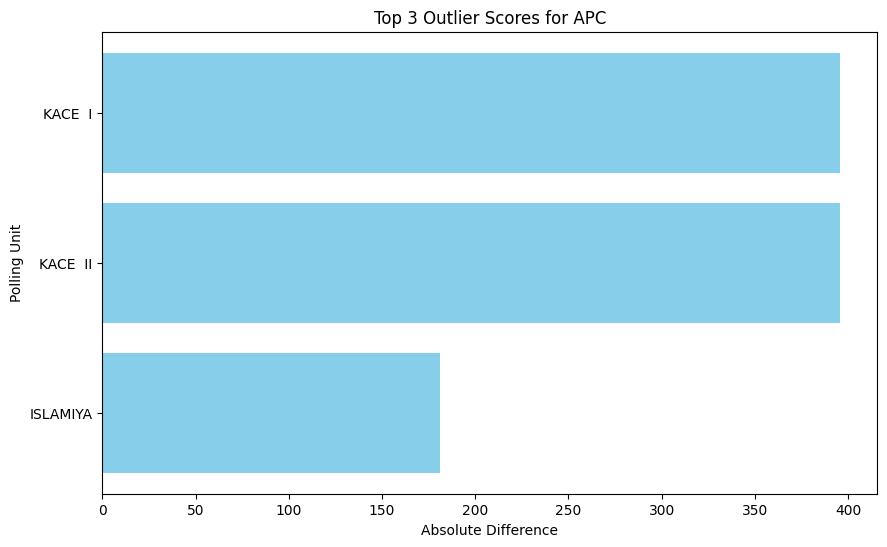

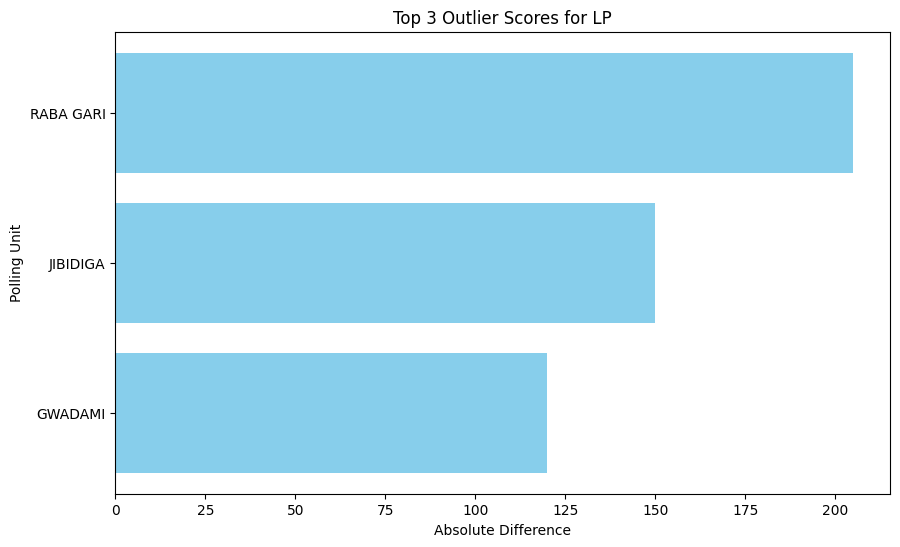

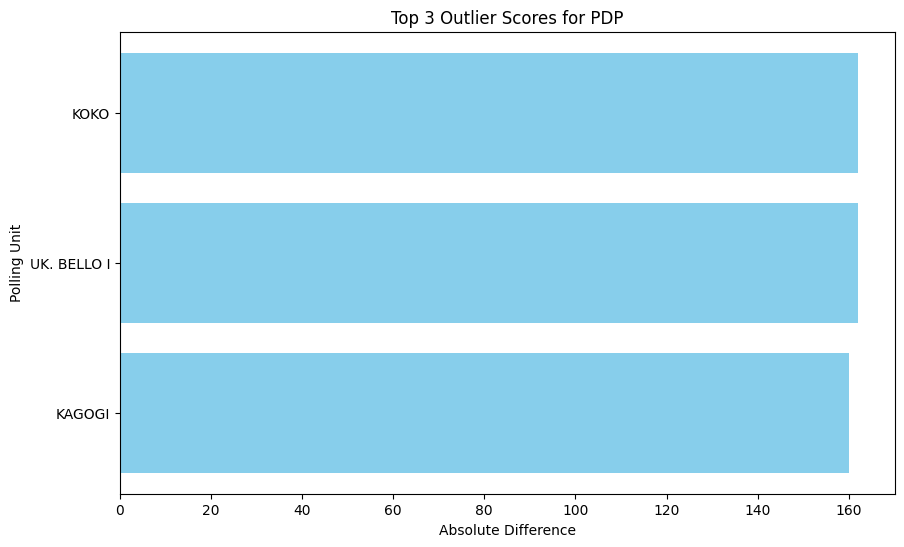

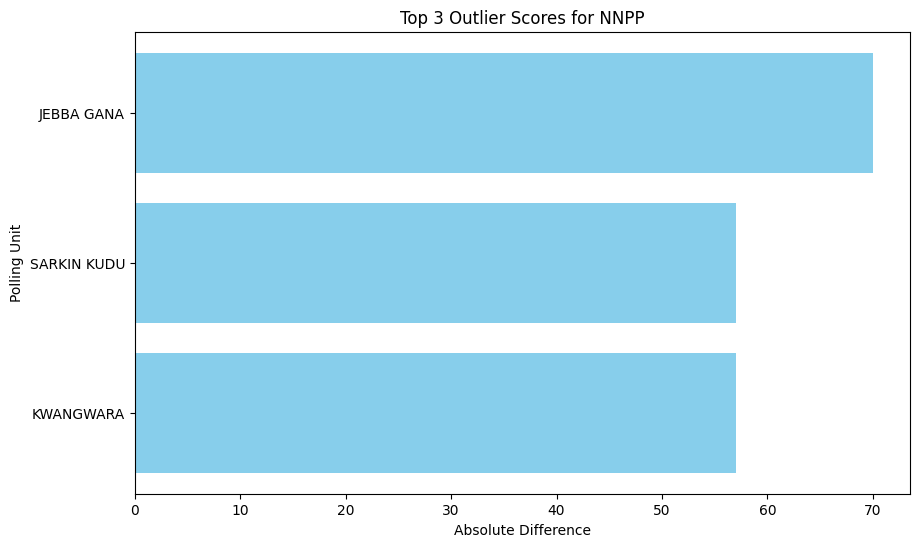

In [13]:
import matplotlib.pyplot as plt

# Function to plot top outliers
def plot_top_outliers(data, party):
    top_outliers = data[data['Party'] == party]
    plt.figure(figsize=(10, 6))
    plt.barh(top_outliers['PU-Name'], top_outliers['Absolute_Difference'], color='skyblue')
    plt.xlabel('Absolute Difference')
    plt.ylabel('Polling Unit')
    plt.title(f'Top 3 Outlier Scores for {party}')
    plt.gca().invert_yaxis()
    plt.show()

# Plot top outliers for each party
plot_top_outliers(top_outliers, 'APC')
plot_top_outliers(top_outliers, 'LP')
plot_top_outliers(top_outliers, 'PDP')
plot_top_outliers(top_outliers, 'NNPP')
